In [46]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
%autosave 20

Autosaving every 20 seconds


### Import Libraries

In [82]:
#Torch Libs
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, utils
from torch.optim.lr_scheduler import StepLR, OneCycleLR

#Utility and Plot Libs
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from skimage import io
import matplotlib.pyplot as plt
from tqdm import tqdm

from IPython.display import Image


### Pytorch Version check

In [83]:
torch.__version__

'1.13.0'

### Data Transformation

In [84]:
#Need to create a data Trandform function here. there transform objects will be use fulll to apply on data

In [85]:
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-15.0, 15.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       ])


test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       ])

### Creating the Trainning and Testing data  

In [86]:
#Here applying the transform function we hafve created.
#What is target_transform , Need to understand

train = datasets.MNIST('../data', train = True,  transform = train_transforms,  target_transform = None,  download = True)
test  = datasets.MNIST('../data', train = False,  transform = test_transforms,   target_transform = None,  download = True)


In [87]:
type(train)
type(test)

torchvision.datasets.mnist.MNIST

torchvision.datasets.mnist.MNIST

### Creating Data Loader

#### Cuda Checker

In [88]:
cuda = torch.cuda.is_available()
print ('Is Cuda Available ?',cuda)

Is Cuda Available ? True


In [89]:
SEED = 1

if cuda:
    torch.cuda.manual_seed(SEED)
else:
    torch.manual_seed(SEED)

#### Based on the cuda availability we are defining the things

In [90]:
dataloader_args = dict(shuffle = True,batch_size = 128,num_workers = 4, pin_memory = True) if cuda else dict(shuffle = True,batch_size = 64)

In [91]:
dataloader_args

{'shuffle': True, 'batch_size': 128, 'num_workers': 4, 'pin_memory': True}

In [92]:
train_loader = torch.utils.data.DataLoader(train,**dataloader_args)
test_loader = torch.utils.data.DataLoader(test,**dataloader_args)

In [93]:
pwd

'/home/jd/Desktop/Computer vision/Extensive_CV/Batch Normalization & Regularization'

### Extracting Statistics

In [94]:
dataiter = iter(train_loader)
images,label = next(dataiter)

In [95]:
print(images.shape)
print(label.shape)

torch.Size([128, 1, 28, 28])
torch.Size([128])


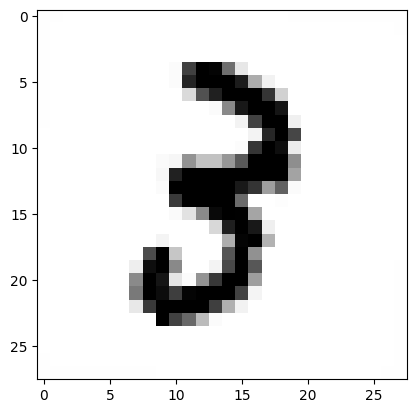

In [96]:
plt.imshow(images[0].numpy().squeeze(),cmap = 'gray_r')

### Plotting all the image

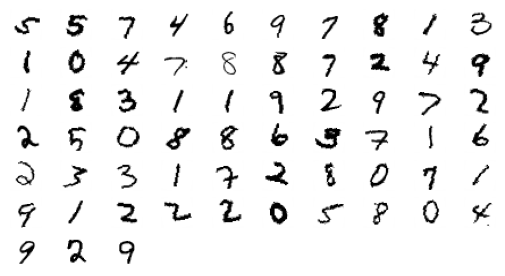

In [97]:
figure = plt.figure()
num_of_images = 63
for index in range(1, num_of_images + 1):
    _= plt.subplot(10, 10, index)
    _= plt.axis('off')
    _= plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

## Model Architecture

## GBN

In [98]:
class GhostBatchNorm(nn.BatchNorm2d):
    """
    From : https://github.com/davidcpage/cifar10-fast/blob/master/bag_of_tricks.ipynb

    Batch norm seems to work best with batch size of around 32. The reasons presumably have to do 
    with noise in the batch statistics and specifically a balance between a beneficial regularising effect 
    at intermediate batch sizes and an excess of noise at small batches.
    
    Our batches are of size 512 and we can't afford to reduce them without taking a serious hit on training times, 
    but we can apply batch norm separately to subsets of a training batch. This technique, known as 'ghost' batch 
    norm, is usually used in a distributed setting but is just as useful when using large batches on a single node. 
    It isn't supported directly in PyTorch but we can roll our own easily enough.
    """
    def __init__(self, num_features, num_splits, eps=1e-05, momentum=0.1, weight=True, bias=True):
        super(GhostBatchNorm, self).__init__(num_features, eps=eps, momentum=momentum)
        self.weight.data.fill_(1.0)
        self.bias.data.fill_(0.0)
        self.weight.requires_grad = weight
        self.bias.requires_grad = bias        
        self.num_splits = num_splits
        self.register_buffer('running_mean', torch.zeros(num_features*self.num_splits))
        self.register_buffer('running_var', torch.ones(num_features*self.num_splits))

    def train(self, mode=True):
        if (self.training is True) and (mode is False):
            self.running_mean = torch.mean(self.running_mean.view(self.num_splits, self.num_features), dim=0).repeat(self.num_splits)
            self.running_var = torch.mean(self.running_var.view(self.num_splits, self.num_features), dim=0).repeat(self.num_splits)
        return super(GhostBatchNorm, self).train(mode)
        
    def forward(self, input):
        N, C, H, W = input.shape
        if self.training or not self.track_running_stats:
            return F.batch_norm(
                input.view(-1, C*self.num_splits, H, W), self.running_mean, self.running_var, 
                self.weight.repeat(self.num_splits), self.bias.repeat(self.num_splits),
                True, self.momentum, self.eps).view(N, C, H, W) 
        else:
            return F.batch_norm(
                input, self.running_mean[:self.num_features], self.running_var[:self.num_features], 
                self.weight, self.bias, False, self.momentum, self.eps)



In [99]:

class Net(nn.Module):
    def __init__(self,ghost = False):
        super(Net, self).__init__()
        self.dropout_value = 0.05
        # Input Block
        print('GHOST BHAI is ',ghost)
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10) if ghost is False else GhostBatchNorm(10, num_splits=4, weight=False),
            nn.Dropout(self.dropout_value),
            nn.ReLU()
        ) # input_size = 28 output_size = 26 receptive_field = 3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10) if ghost is False else GhostBatchNorm(10, num_splits=4, weight=False),
            nn.Dropout(self.dropout_value),
            nn.ReLU(),
        ) # input_size = 26 output_size = 24 receptive_field = 5
        
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10) if ghost is False else GhostBatchNorm(10, num_splits=64//32, weight=False),
            nn.Dropout(self.dropout_value),
            nn.ReLU()
        ) # input_size = 24 output_size = 22 receptive_field = 7       
        
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10) if ghost is False else GhostBatchNorm(10, num_splits=64//32, weight=False),
            nn.Dropout(self.dropout_value),
            nn.ReLU()
        ) # input_size = 22 output_size = 20 receptive_field = 9        
        
        
        self.pool1 = nn.MaxPool2d(2, 2) # input_size = 20 output_size = 10 receptive_field = 18

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10) if ghost is False else GhostBatchNorm(10, num_splits=64//32, weight=False),
            nn.Dropout(self.dropout_value),
            nn.ReLU()
        ) # input_size = 10 output_size = 8 receptive_field = 20
        
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16) if ghost is False else GhostBatchNorm(16, num_splits=64//32, weight=False),
            nn.Dropout(self.dropout_value),
            nn.ReLU()
        ) # input_size = 8 output_size = 6 receptive_field = 22
        
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16) if ghost is False else GhostBatchNorm(16, num_splits=64//32, weight=False),
            nn.Dropout(self.dropout_value),
            nn.ReLU()
        ) # input_size = 6 output_size = 4 receptive_field = 24
        
        self.gap = nn.AvgPool2d(kernel_size=(4,4)) 
        
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # input_size = 1 output_size = 1  receptive_field = 24
        

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.pool1(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)  
        x = self.convblock8(x)
        x = x.view(-1, 10)
        
        return F.log_softmax(x, dim=-1)

### Model Param

In [100]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
GHOST BHAI is  False
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
       BatchNorm2d-2           [-1, 10, 26, 26]              20
           Dropout-3           [-1, 10, 26, 26]               0
              ReLU-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 10, 24, 24]             900
       BatchNorm2d-6           [-1, 10, 24, 24]              20
           Dropout-7           [-1, 10, 24, 24]               0
              ReLU-8           [-1, 10, 24, 24]               0
            Conv2d-9           [-1, 10, 22, 22]             900
      BatchNorm2d-10           [-1, 10, 22, 22]              20
          Dropout-11           [-1, 10, 22, 22]               0
             ReLU-12           [-1, 10, 22, 22]               0
           Conv2d-13           [-1, 10, 20, 20]             900
      BatchNo

In [101]:
#L1 Loss Calculator
def L1_Loss_calc(model, factor=0.0005):
    l1_crit = nn.L1Loss(size_average=False)
    reg_loss = 0
    for param in model.parameters():
        #zero_vector = torch.rand_like(param)*0
        zero_vector = torch.zeros_like(param)
        reg_loss += l1_crit(param,zero_vector)
    return factor * reg_loss

In [102]:
from tqdm import tqdm

def train(model, device, train_loader, optimizer, epoch,scheduler,l1_check =False):
    model.train()
    pbar = tqdm(train_loader)
    train_loss = 0
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        # get samples
        data, target = data.to(device), target.to(device)

        # Init
        optimizer.zero_grad()
        
        # Predict
        y_pred = model(data)

        # Calculate loss
        loss = F.nll_loss(y_pred, target)
        #adding L1 loss function call 

        if( l1_check == True ):
            regloss = L1_Loss_calc(model, 0.0005)
            regloss /= len(data) # by batch size
            loss += regloss

        train_loss += loss.item()

        # Backpropagation
        loss.backward()
        optimizer.step()

        # Update pbar-tqdm

        pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

#         pbar.set_description(desc= f'Loss={loss.item():0.6f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
        pbar.set_description(desc= f'Loss={train_loss/(batch_idx+1):0.6f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

    train_loss /= len(train_loader)
    
    acc = np.round(100. * correct/len(train_loader.dataset),2) #processed # 
    scheduler.step()
    
    return acc, np.round(train_loss,5)

In [103]:
def test(model, device, test_loader,l1_check = False):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    
    if( l1_check == True ):
            regloss = L1_Loss_calc(model, 0.0005)
            regloss /= len(data) # by batch size
            test_loss += regloss

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(test_loss, correct, len(test_loader.dataset),100 * correct / len(test_loader.dataset)))
    acc = 100 * correct /len(test_loader.dataset)
    acc = np.round(acc,2)
    
    return acc, test_loss
    

### Temp Store

### Lets add L2 

In [104]:
len(train_loader)

469

In [105]:
def model_building(typ, model, device,train_loader, test_loader,l1_check = False, l2_val = 0, EPOCHS = 3,learning_rate = 0.01):
    
    train_losses = []
    train_acc = []
    test_losses = []
    test_acc = []
    
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_loader), epochs=EPOCHS)
    
    print ('Model with ', typ)
    for epoch in range(1,EPOCHS):
        print("EPOCH:", epoch)
        acc,loss =  train(model, device, train_loader, optimizer, epoch,scheduler,l1_check= True)
        acc
        train_acc.append(acc)
        train_losses.append(loss)
        
        acc,loss =  test(model, device, test_loader,l1_check= True)
        test_acc.append(acc)
        test_losses.append(loss)
        
    return train_acc,train_losses,test_acc,test_losses

## Missclassifications


In [106]:
def miss_classification(typ, model, device, testloader, num_of_images = 25, filename='missclass'):
    model.eval()
    misclassified_cnt = 0
    fig = plt.figure(figsize=(12,12))
    print ('Missclassification on ', typ)
    for data, target in testloader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True)
        pred_marker = pred.eq(target.view_as(pred))   
        wrong_idx = (pred_marker == False).nonzero()
        for idx in wrong_idx:
            index = idx[0].item()
            title = "Actul:{}, Pred:{}".format(target[index].item(), pred[index][0].item())
            ax = fig.add_subplot(5, 5, misclassified_cnt+1, xticks=[], yticks=[]) 
            ax.set_title(title)
            plt.imshow(data[index].cpu().numpy().squeeze(), cmap='gray_r')
            misclassified_cnt += 1
            if(misclassified_cnt==num_of_images):
                break
        if(misclassified_cnt==num_of_images):
            break
    
    fig.savefig(typ + '_missclassified_images'+ '.jpg') 
    return

In [107]:
def plot_acc_loss(typ, train_acc,train_losses,test_acc,test_losses):
    fig, axs = plt.subplots(1,2,figsize = (20,5))
    print ('Accuracy model on  ', typ)
    plt.autoscale()
    axs[0].plot(train_acc,color = 'red')
    axs[0].plot(test_acc,color = 'green')
    title = 'Training/testing accuracy'
    axs[0].set_title(title)
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['train acc','test acc'], loc='best')
#     fig.set_figheight(10)
#     fig.set_figwidth(20)
       
    axs[1].plot(train_losses,color = 'red')
    axs[1].plot(test_losses,color = 'green')
    title = 'Training/Testing Loss'
    axs[1].set_title(title)
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['train loss','test loss'], loc='best')
    plt.title(typ + 'model Accuracy Vs Loss')
#     fig.set_figheight(10)
#     fig.set_figwidth(20)

    plt.show()

In [108]:
def plot_all(train_acc1=[0,0] ,train_losses1=[0,0] ,test_acc1 =[0,0],test_losses1=[0,0],train_acc2=[0,0] ,train_losses2=[0,0] ,test_acc2=[0,0] ,test_losses2=[0,0],train_acc3=[0,0] ,train_losses3=[0,0] ,test_acc3 =[0,0],test_losses3=[0,0],train_acc4=[0,0] ,train_losses4 =[0,0],test_acc4=[0,0] ,test_losses4=[0,0],train_acc5 =[0,0],train_losses5 =[0,0],test_acc5=[0,0] ,test_losses5=[0,0]):
    fig,ax = plt.subplots(1,2,figsize=(30,7))
    
    # ploting the Accuracy 
    
    ax[0].plot(train_acc1)
    ax[0].plot(train_acc2)
    ax[0].plot(train_acc3)
    ax[0].plot(train_acc4)
    ax[0].plot(train_acc5)
    ax[0].set_title('Model Accuracy')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_xlabel('Epochs')
    ax[0].legend(['L1+BN_acc','L2+BN_acc','L1 & L2 + BN_acc','GBN_acc','L1 & L2 + GBN_acc'], loc='best')
    #Ploting the losses 
    
    ax[1].plot(train_losses1)
    ax[1].plot(train_losses2)
    ax[1].plot(train_losses3)
    ax[1].plot(train_losses4)
    ax[1].plot(train_losses5)
    ax[1].set_title('Model Loss')
    ax[1].set_ylabel('Loss')
    ax[1].set_xlabel('Epochs')
    ax[1].legend(['L1+BN_loss','L2+BN _loss','L1 & L2 + BN_loss','GBN_loss','L1 & L2 + GBN_loss'], loc='best')
    
    plt.show()
    fig.savefig('Comparision.')

In [111]:
def modelcalling(models,EPOCHS,learning_rate ):
    print ('The Number of Epochs are :', EPOCHS)
    for typ in models:
        if typ == 'L1+BN':
            
            l1_check = True
            l2_val = 0
            ghost = False
            
            model =  Net(ghost).to(device)
            train_acc1 ,train_losses1 ,test_acc1 ,test_losses1 = model_building(typ, model, device,train_loader, test_loader,l1_check ,l2_val,EPOCHS,learning_rate)
            try:
                test_losses1 = [i.item() for i in test_losses1 ]
            except:
                pass
            plot_acc_loss(typ, train_acc1 ,train_losses1 ,test_acc1 ,test_losses1)
            miss_classification(typ, model, device, testloader = test_loader, num_of_images = 25, filename=typ)
#             Image(filename= typ + '_missclassified_images'+ '.png' )
            
#             modelparams = {'train_acc':train_acc1,'test_acc':test_acc1,'train_losses':train_losses1,'test_losses':test_losses1}
#             file = pd.DataFrame(modelparams)
#             file.to_csv(typ + '_missclassified_images'+ '.png')


        elif typ == 'L2+BN':
            
            l1_check = False
            l2_val = 0.03
            ghost = False
            
            model =  Net(ghost).to(device)
            train_acc2 ,train_losses2 ,test_acc2 ,test_losses2 = model_building(typ, model, device,train_loader, test_loader,l1_check,l2_val,EPOCHS,learning_rate)
            try:
                test_losses2 = [i.item() for i in test_losses2 ]
            except:
                pass
            
            plot_acc_loss(typ, train_acc2 ,train_losses2 ,test_acc2 ,test_losses2)
            miss_classification(typ, model, device, testloader = test_loader, num_of_images = 25, filename=typ)
#             Image(filename= typ + '_missclassified_images'+ '.png' )
            
#             modelparams = {'train_acc':train_acc2,'test_acc':test_acc2,'train_losses':train_losses2,'test_losses':test_losses2}
#             file = pd.DataFrame(modelparams)
#             file.to_csv(typ + 'param'+'.csv')

            
        elif typ == 'L1 & L2 + BN':
            
            l1_check = True
            l2_val = 0.03
            ghost = False
            
            model =  Net(ghost).to(device)
            train_acc3 ,train_losses3 ,test_acc3 ,test_losses3 = model_building(typ, model, device,train_loader, test_loader,l1_check,l2_val,EPOCHS ,learning_rate)
            try:
                test_losses3 = [i.item() for i in test_losses3 ]
            except:
                pass
            plot_acc_loss(typ, train_acc3 ,train_losses3 ,test_acc3 ,test_losses3)
            miss_classification(typ, model, device, testloader = test_loader, num_of_images = 25, filename=typ)
#             Image(filename= typ + '_missclassified_images'+ '.png' )
            
#             modelparams = {'train_acc':train_acc3,'test_acc':test_acc3,'train_losses':train_losses3,'test_losses':test_losses3}
#             file = pd.DataFrame(modelparams)
#             file.to_csv(typ + 'param'+'.csv')

            
        elif typ == 'GBN':
            
            l1_check = False
            l2_val = 0
            ghost = True
            
            model =  Net(ghost).to(device)
            train_acc4 ,train_losses4 ,test_acc4 ,test_losses4 = model_building(typ, model, device,train_loader, test_loader,l1_check,l2_val,EPOCHS,learning_rate)
            try:
                test_losses4 = [i.item() for i in test_losses4 ]
            except:
                pass
            plot_acc_loss(typ, train_acc4 ,train_losses4 ,test_acc4 ,test_losses4)
            miss_classification(typ, model, device, testloader = test_loader, num_of_images = 25, filename=typ)
#             Image(filename= typ + '_missclassified_images'+ '.png' )
            
#             modelparams = {'train_acc':train_acc4,'test_acc':test_acc4,'train_losses':train_losses4,'test_losses':test_losses4}
#             file = pd.DataFrame(modelparams)
#             file.to_csv(typ + 'param'+'.csv')

            
        elif typ == 'L1 & L2 + GBN':
            
            l1_check = True
            l2_val = 0.03
            ghost = True
            
            model =  Net(ghost).to(device)
            train_acc5 ,train_losses5 ,test_acc5 ,test_losses5 = model_building(typ, model, device,train_loader, test_loader,l1_check , l2_val , EPOCHS ,learning_rate)
            try:
                test_losses5 = [i.item() for i in test_losses5 ]
            except:
                pass
            plot_acc_loss(typ, train_acc5 ,train_losses5 ,test_acc5 ,test_losses5)
            miss_classification(typ, model, device, testloader = test_loader, num_of_images = 25, filename=typ)
#             Image(filename= typ + '_missclassified_images'+ '.png' )
            
#             modelparams = {'train_acc':train_acc5,'test_acc':test_acc5,'train_losses':train_losses5,'test_losses':test_losses5}
#             file = pd.DataFrame(modelparams)
#             file.to_csv(typ + 'param'+'.csv')

        
    plot_all(train_acc1 ,train_losses1 ,test_acc1 ,test_losses1,train_acc2 ,train_losses2 ,test_acc2 ,test_losses2,train_acc3 ,train_losses3 ,test_acc3 ,test_losses3,train_acc4 ,train_losses4 ,test_acc4 ,test_losses4,train_acc5 ,train_losses5 ,test_acc5 ,test_losses5)
    
    for i in models:
        name = i + '_missclassified_images.jpg'
        print (name)
        image = io.imread(name)
        plt.subplots(figsize = (20,20))
        plt.imshow(image)
        plt.title(i + '_missclassified_images') 

The Number of Epochs are : 25
GHOST BHAI is  False
Model with  L1+BN
EPOCH: 1


  0%|                                                   | 0/469 [00:00<?, ?it/s]/home/jd/miniconda3/envs/eva/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
Loss=0.770214 Batch_id=468 Accuracy=79.77: 100%|█| 469/469 [00:03<00:00, 122.45i



Test set: Average loss: 0.1764, Accuracy: 9569/10000 (95.69%)

EPOCH: 2


Loss=0.136311 Batch_id=468 Accuracy=96.39: 100%|█| 469/469 [00:03<00:00, 125.55i



Test set: Average loss: 0.0772, Accuracy: 9843/10000 (98.43%)

EPOCH: 3


Loss=0.096434 Batch_id=468 Accuracy=97.35: 100%|█| 469/469 [00:03<00:00, 124.76i



Test set: Average loss: 0.1057, Accuracy: 9730/10000 (97.30%)

EPOCH: 4


Loss=0.079987 Batch_id=468 Accuracy=97.79: 100%|█| 469/469 [00:03<00:00, 126.07i



Test set: Average loss: 0.0656, Accuracy: 9867/10000 (98.67%)

EPOCH: 5


Loss=0.072069 Batch_id=468 Accuracy=97.90: 100%|█| 469/469 [00:03<00:00, 121.17i



Test set: Average loss: 0.0581, Accuracy: 9882/10000 (98.82%)

EPOCH: 6


Loss=0.066528 Batch_id=468 Accuracy=98.06: 100%|█| 469/469 [00:03<00:00, 120.83i



Test set: Average loss: 0.0602, Accuracy: 9890/10000 (98.90%)

EPOCH: 7


Loss=0.061861 Batch_id=468 Accuracy=98.19: 100%|█| 469/469 [00:03<00:00, 123.66i



Test set: Average loss: 0.0496, Accuracy: 9916/10000 (99.16%)

EPOCH: 8


Loss=0.057753 Batch_id=468 Accuracy=98.31: 100%|█| 469/469 [00:03<00:00, 123.60i



Test set: Average loss: 0.0481, Accuracy: 9915/10000 (99.15%)

EPOCH: 9


Loss=0.056851 Batch_id=468 Accuracy=98.32: 100%|█| 469/469 [00:03<00:00, 125.42i



Test set: Average loss: 0.0474, Accuracy: 9918/10000 (99.18%)

EPOCH: 10


Loss=0.052919 Batch_id=468 Accuracy=98.47: 100%|█| 469/469 [00:03<00:00, 122.36i



Test set: Average loss: 0.0511, Accuracy: 9902/10000 (99.02%)

EPOCH: 11


Loss=0.054125 Batch_id=468 Accuracy=98.44: 100%|█| 469/469 [00:03<00:00, 120.20i



Test set: Average loss: 0.0506, Accuracy: 9912/10000 (99.12%)

EPOCH: 12


Loss=0.049591 Batch_id=468 Accuracy=98.56: 100%|█| 469/469 [00:03<00:00, 122.00i



Test set: Average loss: 0.0447, Accuracy: 9923/10000 (99.23%)

EPOCH: 13


Loss=0.048678 Batch_id=468 Accuracy=98.53: 100%|█| 469/469 [00:03<00:00, 122.96i



Test set: Average loss: 0.0475, Accuracy: 9916/10000 (99.16%)

EPOCH: 14


Loss=0.049713 Batch_id=468 Accuracy=98.57: 100%|█| 469/469 [00:03<00:00, 123.90i



Test set: Average loss: 0.0459, Accuracy: 9930/10000 (99.30%)

EPOCH: 15


Loss=0.048166 Batch_id=468 Accuracy=98.59: 100%|█| 469/469 [00:03<00:00, 121.46i



Test set: Average loss: 0.0471, Accuracy: 9921/10000 (99.21%)

EPOCH: 16


Loss=0.044297 Batch_id=468 Accuracy=98.74: 100%|█| 469/469 [00:03<00:00, 117.72i



Test set: Average loss: 0.0446, Accuracy: 9931/10000 (99.31%)

EPOCH: 17


Loss=0.045311 Batch_id=468 Accuracy=98.67: 100%|█| 469/469 [00:03<00:00, 123.86i



Test set: Average loss: 0.0452, Accuracy: 9933/10000 (99.33%)

EPOCH: 18


Loss=0.043830 Batch_id=468 Accuracy=98.72: 100%|█| 469/469 [00:03<00:00, 124.97i



Test set: Average loss: 0.0430, Accuracy: 9928/10000 (99.28%)

EPOCH: 19


Loss=0.043576 Batch_id=468 Accuracy=98.71: 100%|█| 469/469 [00:03<00:00, 122.51i



Test set: Average loss: 0.0450, Accuracy: 9932/10000 (99.32%)

EPOCH: 20


Loss=0.043177 Batch_id=468 Accuracy=98.70: 100%|█| 469/469 [00:03<00:00, 117.76i



Test set: Average loss: 0.0430, Accuracy: 9937/10000 (99.37%)

EPOCH: 21


Loss=0.041771 Batch_id=468 Accuracy=98.77: 100%|█| 469/469 [00:04<00:00, 113.88i



Test set: Average loss: 0.0438, Accuracy: 9939/10000 (99.39%)

EPOCH: 22


Loss=0.042571 Batch_id=468 Accuracy=98.78: 100%|█| 469/469 [00:03<00:00, 119.70i



Test set: Average loss: 0.0423, Accuracy: 9941/10000 (99.41%)

EPOCH: 23


Loss=0.041009 Batch_id=468 Accuracy=98.78: 100%|█| 469/469 [00:04<00:00, 112.63i



Test set: Average loss: 0.0447, Accuracy: 9936/10000 (99.36%)

EPOCH: 24


Loss=0.039180 Batch_id=468 Accuracy=98.86: 100%|█| 469/469 [00:03<00:00, 117.89i



Test set: Average loss: 0.0428, Accuracy: 9939/10000 (99.39%)

Accuracy model on   L1+BN


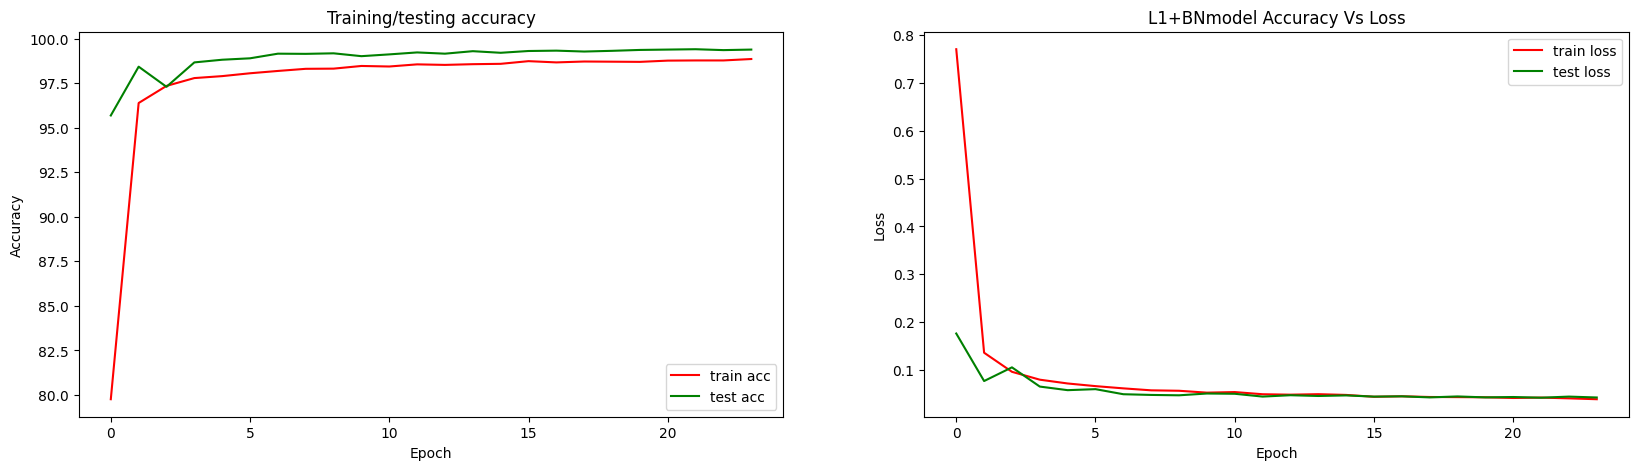

Missclassification on  L1+BN
GHOST BHAI is  False
Model with  L2+BN
EPOCH: 1


  0%|                                                   | 0/469 [00:00<?, ?it/s]/home/jd/miniconda3/envs/eva/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
Loss=0.773897 Batch_id=468 Accuracy=80.28: 100%|█| 469/469 [00:04<00:00, 112.36i



Test set: Average loss: 0.1444, Accuracy: 9672/10000 (96.72%)

EPOCH: 2


Loss=0.140270 Batch_id=468 Accuracy=96.25: 100%|█| 469/469 [00:04<00:00, 110.53i



Test set: Average loss: 0.0758, Accuracy: 9848/10000 (98.48%)

EPOCH: 3


Loss=0.098558 Batch_id=468 Accuracy=97.28: 100%|█| 469/469 [00:03<00:00, 123.10i



Test set: Average loss: 0.0620, Accuracy: 9875/10000 (98.75%)

EPOCH: 4


Loss=0.081328 Batch_id=468 Accuracy=97.72: 100%|█| 469/469 [00:03<00:00, 122.91i



Test set: Average loss: 0.0611, Accuracy: 9874/10000 (98.74%)

EPOCH: 5


Loss=0.073144 Batch_id=468 Accuracy=97.88: 100%|█| 469/469 [00:03<00:00, 119.98i



Test set: Average loss: 0.0559, Accuracy: 9891/10000 (98.91%)

EPOCH: 6


Loss=0.065338 Batch_id=468 Accuracy=98.01: 100%|█| 469/469 [00:03<00:00, 117.28i



Test set: Average loss: 0.0564, Accuracy: 9886/10000 (98.86%)

EPOCH: 7


Loss=0.061217 Batch_id=468 Accuracy=98.19: 100%|█| 469/469 [00:04<00:00, 116.85i



Test set: Average loss: 0.0528, Accuracy: 9888/10000 (98.88%)

EPOCH: 8


Loss=0.058713 Batch_id=468 Accuracy=98.27: 100%|█| 469/469 [00:04<00:00, 114.66i



Test set: Average loss: 0.0504, Accuracy: 9906/10000 (99.06%)

EPOCH: 9


Loss=0.055039 Batch_id=468 Accuracy=98.41: 100%|█| 469/469 [00:04<00:00, 113.36i



Test set: Average loss: 0.0513, Accuracy: 9904/10000 (99.04%)

EPOCH: 10


Loss=0.054795 Batch_id=468 Accuracy=98.44: 100%|█| 469/469 [00:04<00:00, 110.34i



Test set: Average loss: 0.0492, Accuracy: 9909/10000 (99.09%)

EPOCH: 11


Loss=0.051760 Batch_id=468 Accuracy=98.48: 100%|█| 469/469 [00:04<00:00, 111.14i



Test set: Average loss: 0.0472, Accuracy: 9913/10000 (99.13%)

EPOCH: 12


Loss=0.048900 Batch_id=468 Accuracy=98.59: 100%|█| 469/469 [00:04<00:00, 110.40i



Test set: Average loss: 0.0467, Accuracy: 9924/10000 (99.24%)

EPOCH: 13


Loss=0.050124 Batch_id=468 Accuracy=98.53: 100%|█| 469/469 [00:04<00:00, 113.29i



Test set: Average loss: 0.0463, Accuracy: 9915/10000 (99.15%)

EPOCH: 14


Loss=0.048202 Batch_id=468 Accuracy=98.56: 100%|█| 469/469 [00:04<00:00, 110.76i



Test set: Average loss: 0.0467, Accuracy: 9927/10000 (99.27%)

EPOCH: 15


Loss=0.047104 Batch_id=468 Accuracy=98.61: 100%|█| 469/469 [00:04<00:00, 114.43i



Test set: Average loss: 0.0474, Accuracy: 9918/10000 (99.18%)

EPOCH: 16


Loss=0.045517 Batch_id=468 Accuracy=98.68: 100%|█| 469/469 [00:04<00:00, 108.17i



Test set: Average loss: 0.0470, Accuracy: 9909/10000 (99.09%)

EPOCH: 17


Loss=0.044021 Batch_id=468 Accuracy=98.75: 100%|█| 469/469 [00:04<00:00, 109.80i



Test set: Average loss: 0.0447, Accuracy: 9923/10000 (99.23%)

EPOCH: 18


Loss=0.043594 Batch_id=468 Accuracy=98.75: 100%|█| 469/469 [00:04<00:00, 109.58i



Test set: Average loss: 0.0450, Accuracy: 9927/10000 (99.27%)

EPOCH: 19


Loss=0.043056 Batch_id=468 Accuracy=98.72: 100%|█| 469/469 [00:04<00:00, 110.57i



Test set: Average loss: 0.0481, Accuracy: 9922/10000 (99.22%)

EPOCH: 20


Loss=0.041944 Batch_id=468 Accuracy=98.77: 100%|█| 469/469 [00:04<00:00, 109.96i



Test set: Average loss: 0.0453, Accuracy: 9933/10000 (99.33%)

EPOCH: 21


Loss=0.041317 Batch_id=468 Accuracy=98.80: 100%|█| 469/469 [00:04<00:00, 106.05i



Test set: Average loss: 0.0451, Accuracy: 9936/10000 (99.36%)

EPOCH: 22


Loss=0.041874 Batch_id=468 Accuracy=98.78: 100%|█| 469/469 [00:04<00:00, 110.76i



Test set: Average loss: 0.0445, Accuracy: 9928/10000 (99.28%)

EPOCH: 23


Loss=0.042172 Batch_id=468 Accuracy=98.75: 100%|█| 469/469 [00:04<00:00, 108.80i



Test set: Average loss: 0.0452, Accuracy: 9929/10000 (99.29%)

EPOCH: 24


Loss=0.038948 Batch_id=468 Accuracy=98.87: 100%|█| 469/469 [00:04<00:00, 110.74i



Test set: Average loss: 0.0453, Accuracy: 9926/10000 (99.26%)

Accuracy model on   L2+BN


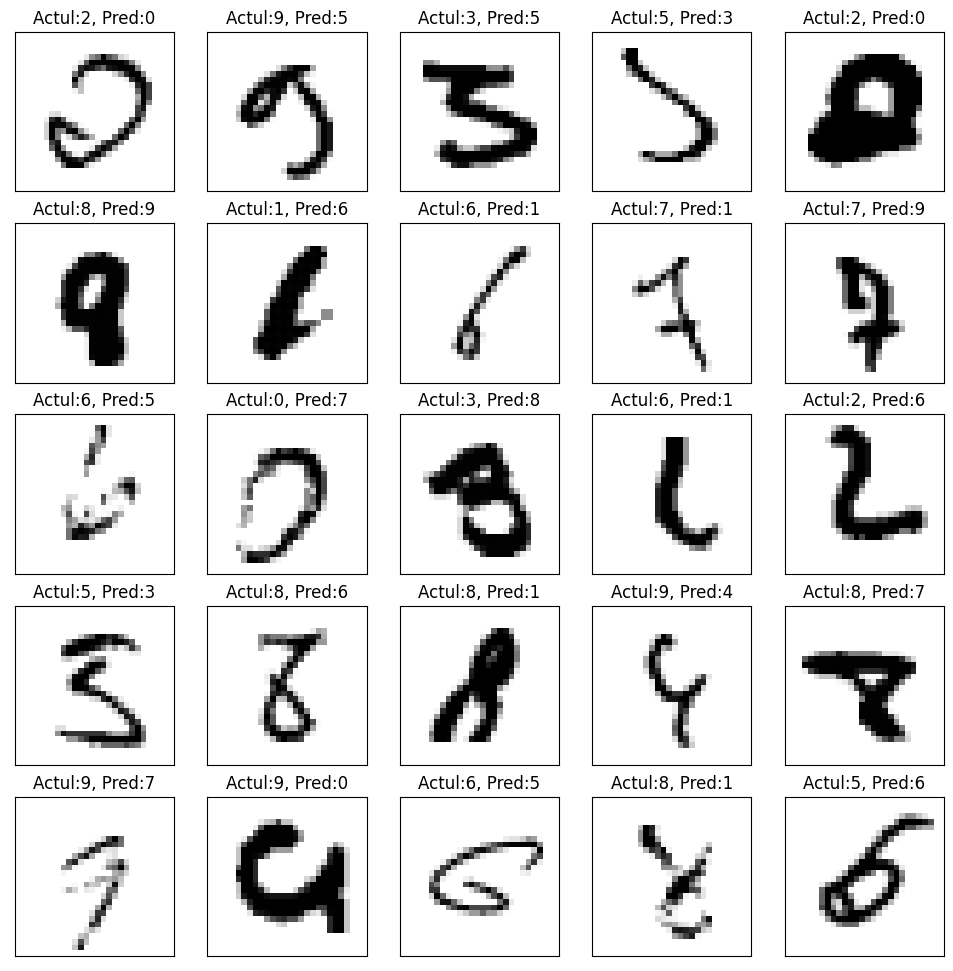

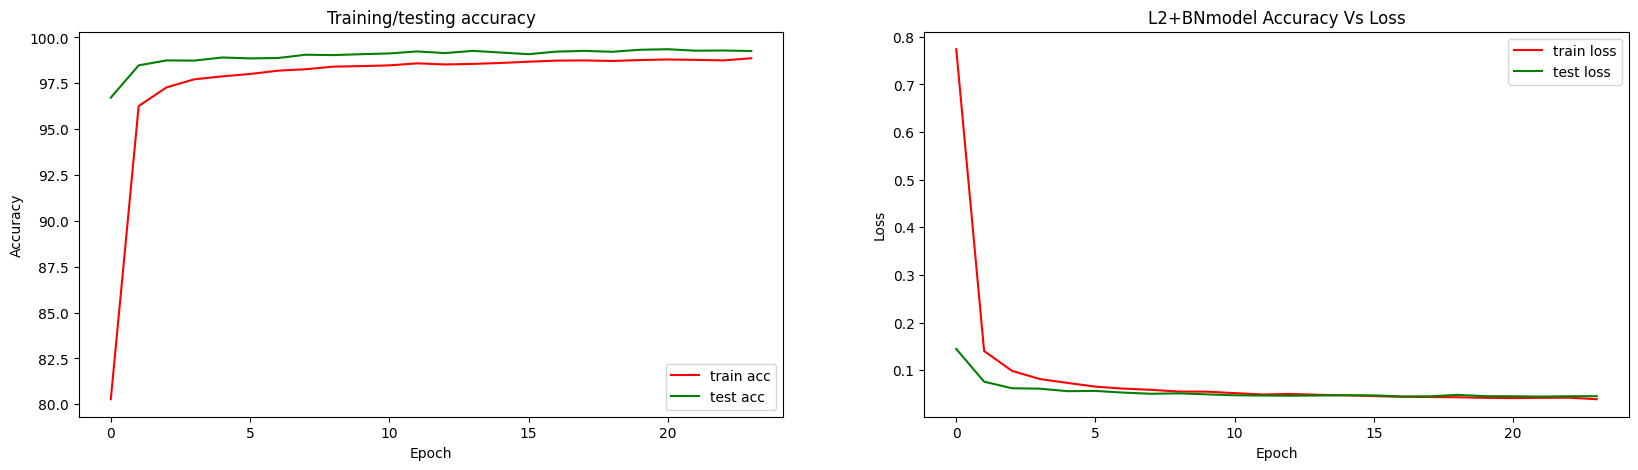

Missclassification on  L2+BN
GHOST BHAI is  False
Model with  L1 & L2 + BN
EPOCH: 1


  0%|                                                   | 0/469 [00:00<?, ?it/s]/home/jd/miniconda3/envs/eva/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
Loss=0.816566 Batch_id=468 Accuracy=78.07: 100%|█| 469/469 [00:04<00:00, 102.18i



Test set: Average loss: 0.1478, Accuracy: 9680/10000 (96.80%)

EPOCH: 2


Loss=0.128831 Batch_id=468 Accuracy=96.71: 100%|█| 469/469 [00:04<00:00, 107.32i



Test set: Average loss: 0.0799, Accuracy: 9826/10000 (98.26%)

EPOCH: 3


Loss=0.091226 Batch_id=468 Accuracy=97.51: 100%|█| 469/469 [00:04<00:00, 113.52i



Test set: Average loss: 0.0642, Accuracy: 9869/10000 (98.69%)

EPOCH: 4


Loss=0.076963 Batch_id=468 Accuracy=97.84: 100%|█| 469/469 [00:04<00:00, 106.01i



Test set: Average loss: 0.0620, Accuracy: 9870/10000 (98.70%)

EPOCH: 5


Loss=0.068899 Batch_id=468 Accuracy=98.04: 100%|█| 469/469 [00:04<00:00, 111.48i



Test set: Average loss: 0.0551, Accuracy: 9896/10000 (98.96%)

EPOCH: 6


Loss=0.062609 Batch_id=468 Accuracy=98.20: 100%|█| 469/469 [00:04<00:00, 115.30i



Test set: Average loss: 0.0537, Accuracy: 9897/10000 (98.97%)

EPOCH: 7


Loss=0.060850 Batch_id=468 Accuracy=98.25: 100%|█| 469/469 [00:03<00:00, 117.56i



Test set: Average loss: 0.0525, Accuracy: 9897/10000 (98.97%)

EPOCH: 8


Loss=0.058452 Batch_id=468 Accuracy=98.26: 100%|█| 469/469 [00:04<00:00, 113.62i



Test set: Average loss: 0.0492, Accuracy: 9913/10000 (99.13%)

EPOCH: 9


Loss=0.054495 Batch_id=468 Accuracy=98.38: 100%|█| 469/469 [00:04<00:00, 113.66i



Test set: Average loss: 0.0475, Accuracy: 9913/10000 (99.13%)

EPOCH: 10


Loss=0.052935 Batch_id=468 Accuracy=98.49: 100%|█| 469/469 [00:04<00:00, 109.98i



Test set: Average loss: 0.0506, Accuracy: 9909/10000 (99.09%)

EPOCH: 11


Loss=0.050904 Batch_id=468 Accuracy=98.53: 100%|█| 469/469 [00:04<00:00, 112.53i



Test set: Average loss: 0.0499, Accuracy: 9907/10000 (99.07%)

EPOCH: 12


Loss=0.049573 Batch_id=468 Accuracy=98.61: 100%|█| 469/469 [00:04<00:00, 110.76i



Test set: Average loss: 0.0474, Accuracy: 9917/10000 (99.17%)

EPOCH: 13


Loss=0.047734 Batch_id=468 Accuracy=98.60: 100%|█| 469/469 [00:04<00:00, 113.00i



Test set: Average loss: 0.0502, Accuracy: 9912/10000 (99.12%)

EPOCH: 14


Loss=0.045714 Batch_id=468 Accuracy=98.67: 100%|█| 469/469 [00:04<00:00, 113.76i



Test set: Average loss: 0.0487, Accuracy: 9919/10000 (99.19%)

EPOCH: 15


Loss=0.046248 Batch_id=468 Accuracy=98.68: 100%|█| 469/469 [00:04<00:00, 111.45i



Test set: Average loss: 0.0504, Accuracy: 9908/10000 (99.08%)

EPOCH: 16


Loss=0.045343 Batch_id=468 Accuracy=98.69: 100%|█| 469/469 [00:04<00:00, 112.78i



Test set: Average loss: 0.0479, Accuracy: 9920/10000 (99.20%)

EPOCH: 17


Loss=0.042786 Batch_id=468 Accuracy=98.78: 100%|█| 469/469 [00:04<00:00, 113.64i



Test set: Average loss: 0.0455, Accuracy: 9933/10000 (99.33%)

EPOCH: 18


Loss=0.042912 Batch_id=468 Accuracy=98.78: 100%|█| 469/469 [00:04<00:00, 113.15i



Test set: Average loss: 0.0442, Accuracy: 9929/10000 (99.29%)

EPOCH: 19


Loss=0.043741 Batch_id=468 Accuracy=98.77: 100%|█| 469/469 [00:04<00:00, 115.06i



Test set: Average loss: 0.0457, Accuracy: 9930/10000 (99.30%)

EPOCH: 20


Loss=0.043403 Batch_id=468 Accuracy=98.73: 100%|█| 469/469 [00:04<00:00, 115.63i



Test set: Average loss: 0.0430, Accuracy: 9937/10000 (99.37%)

EPOCH: 21


Loss=0.041954 Batch_id=468 Accuracy=98.75: 100%|█| 469/469 [00:04<00:00, 115.28i



Test set: Average loss: 0.0450, Accuracy: 9929/10000 (99.29%)

EPOCH: 22


Loss=0.041045 Batch_id=468 Accuracy=98.82: 100%|█| 469/469 [00:04<00:00, 113.35i



Test set: Average loss: 0.0467, Accuracy: 9931/10000 (99.31%)

EPOCH: 23


Loss=0.040611 Batch_id=468 Accuracy=98.84: 100%|█| 469/469 [00:04<00:00, 110.72i



Test set: Average loss: 0.0454, Accuracy: 9934/10000 (99.34%)

EPOCH: 24


Loss=0.040530 Batch_id=468 Accuracy=98.83: 100%|█| 469/469 [00:04<00:00, 114.29i



Test set: Average loss: 0.0469, Accuracy: 9924/10000 (99.24%)

Accuracy model on   L1 & L2 + BN


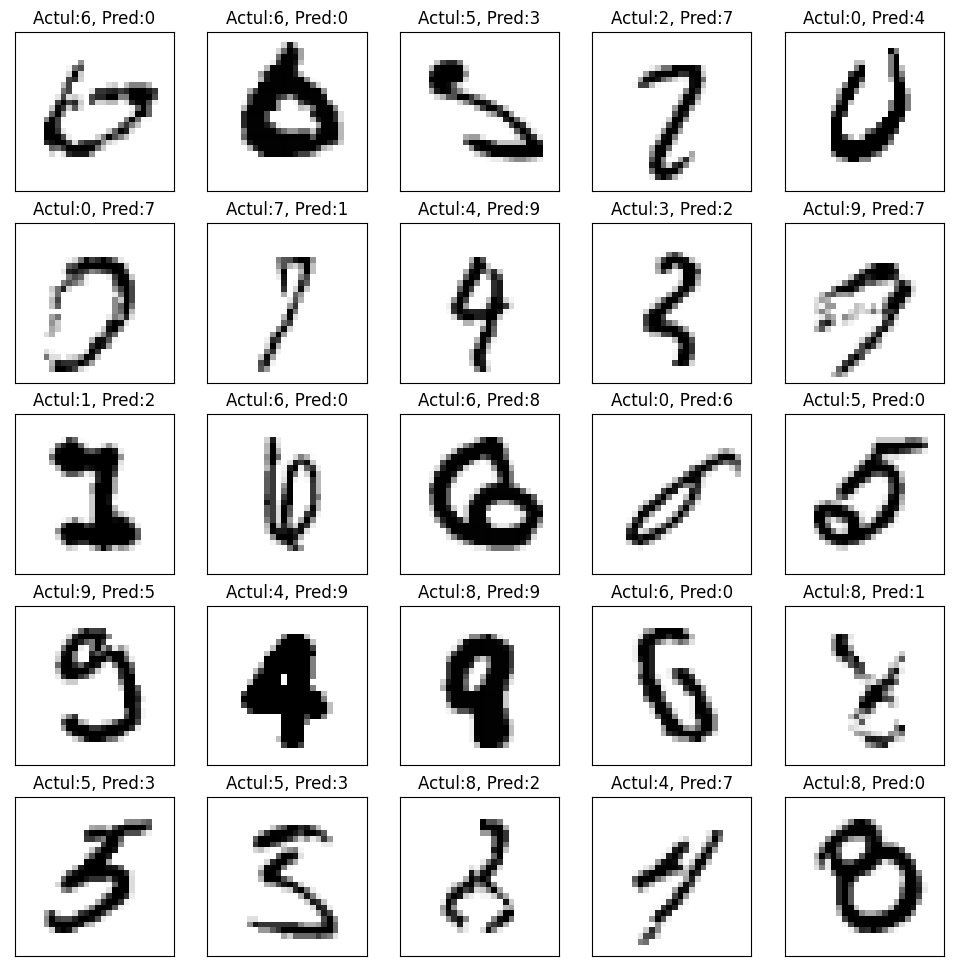

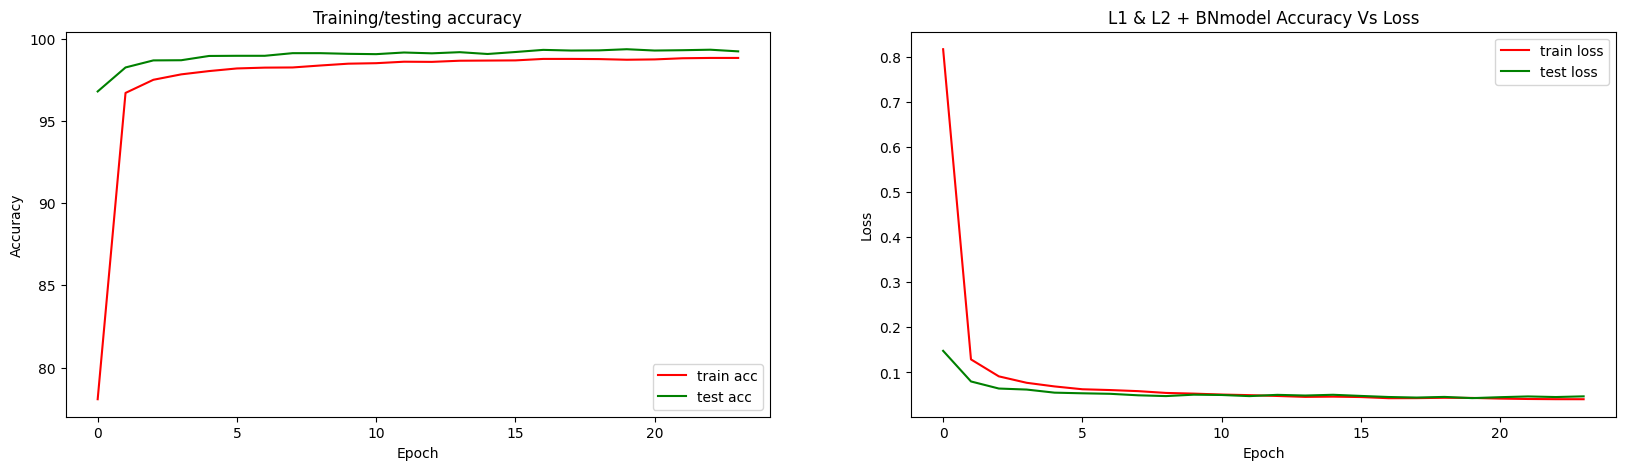

Missclassification on  L1 & L2 + BN
GHOST BHAI is  True
Model with  GBN
EPOCH: 1


  0%|                                                   | 0/469 [00:00<?, ?it/s]/home/jd/miniconda3/envs/eva/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
Loss=0.951905 Batch_id=468 Accuracy=75.43: 100%|█| 469/469 [00:04<00:00, 113.47i



Test set: Average loss: 0.2434, Accuracy: 9478/10000 (94.78%)

EPOCH: 2


Loss=0.188670 Batch_id=468 Accuracy=95.91: 100%|█| 469/469 [00:04<00:00, 112.41i



Test set: Average loss: 0.0992, Accuracy: 9787/10000 (97.87%)

EPOCH: 3


Loss=0.125420 Batch_id=468 Accuracy=96.97: 100%|█| 469/469 [00:04<00:00, 114.88i



Test set: Average loss: 0.0896, Accuracy: 9819/10000 (98.19%)

EPOCH: 4


Loss=0.103429 Batch_id=468 Accuracy=97.39: 100%|█| 469/469 [00:04<00:00, 112.20i



Test set: Average loss: 0.0634, Accuracy: 9885/10000 (98.85%)

EPOCH: 5


Loss=0.088250 Batch_id=468 Accuracy=97.72: 100%|█| 469/469 [00:04<00:00, 111.45i



Test set: Average loss: 0.0584, Accuracy: 9894/10000 (98.94%)

EPOCH: 6


Loss=0.080692 Batch_id=468 Accuracy=97.92: 100%|█| 469/469 [00:04<00:00, 109.55i



Test set: Average loss: 0.0563, Accuracy: 9886/10000 (98.86%)

EPOCH: 7


Loss=0.076261 Batch_id=468 Accuracy=97.95: 100%|█| 469/469 [00:04<00:00, 110.28i



Test set: Average loss: 0.0624, Accuracy: 9887/10000 (98.87%)

EPOCH: 8


Loss=0.071260 Batch_id=468 Accuracy=98.06: 100%|█| 469/469 [00:04<00:00, 112.57i



Test set: Average loss: 0.0523, Accuracy: 9906/10000 (99.06%)

EPOCH: 9


Loss=0.069145 Batch_id=468 Accuracy=98.10: 100%|█| 469/469 [00:04<00:00, 115.80i



Test set: Average loss: 0.0505, Accuracy: 9918/10000 (99.18%)

EPOCH: 10


Loss=0.065670 Batch_id=468 Accuracy=98.21: 100%|█| 469/469 [00:04<00:00, 115.19i



Test set: Average loss: 0.0489, Accuracy: 9918/10000 (99.18%)

EPOCH: 11


Loss=0.063755 Batch_id=468 Accuracy=98.28: 100%|█| 469/469 [00:04<00:00, 116.29i



Test set: Average loss: 0.0492, Accuracy: 9918/10000 (99.18%)

EPOCH: 12


Loss=0.062121 Batch_id=468 Accuracy=98.22: 100%|█| 469/469 [00:04<00:00, 106.56i



Test set: Average loss: 0.0489, Accuracy: 9912/10000 (99.12%)

EPOCH: 13


Loss=0.059753 Batch_id=468 Accuracy=98.34: 100%|█| 469/469 [00:04<00:00, 111.82i



Test set: Average loss: 0.0478, Accuracy: 9915/10000 (99.15%)

EPOCH: 14


Loss=0.057986 Batch_id=468 Accuracy=98.36: 100%|█| 469/469 [00:04<00:00, 106.44i



Test set: Average loss: 0.0487, Accuracy: 9924/10000 (99.24%)

EPOCH: 15


Loss=0.059093 Batch_id=468 Accuracy=98.31: 100%|█| 469/469 [00:04<00:00, 110.45i



Test set: Average loss: 0.0474, Accuracy: 9922/10000 (99.22%)

EPOCH: 16


Loss=0.055347 Batch_id=468 Accuracy=98.53: 100%|█| 469/469 [00:04<00:00, 114.63i



Test set: Average loss: 0.0484, Accuracy: 9910/10000 (99.10%)

EPOCH: 17


Loss=0.055664 Batch_id=468 Accuracy=98.45: 100%|█| 469/469 [00:04<00:00, 108.84i



Test set: Average loss: 0.0475, Accuracy: 9918/10000 (99.18%)

EPOCH: 18


Loss=0.054669 Batch_id=468 Accuracy=98.47: 100%|█| 469/469 [00:04<00:00, 108.02i



Test set: Average loss: 0.0509, Accuracy: 9912/10000 (99.12%)

EPOCH: 19


Loss=0.053089 Batch_id=274 Accuracy=98.50:  58%|▌| 270/469 [00:02<00:01, 103.02i

In [ ]:
models = ['L1+BN','L2+BN','L1 & L2 + BN','GBN','L1 & L2 + GBN']
train_acc1 ,train_losses1 ,test_acc1 ,test_losses1 = modelcalling(models,EPOCHS= 25,learning_rate = 0.01)

### Testing  